In [30]:
import os
import sys
import arxiv

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.schema import Document
from langchain import hub

from langchain_openai.embeddings import OpenAIEmbeddings
from langchain_openai import ChatOpenAI

from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field


from langchain_community.document_loaders import PyPDFLoader
from langchain_community.vectorstores import Chroma
from langchain_community.tools.tavily_search import TavilySearchResults

from langgraph.graph import END, StateGraph


from typing_extensions import TypedDict
from typing import List, Literal

from dotenv import load_dotenv
load_dotenv()

True

In [31]:
PAPERS = ['2205.14135', '2005.14165', '1706.03762', '2403.14403', '2310.11511', '2401.15884']

In [32]:
os.makedirs('../papers_dir/', exist_ok=True)
client = arxiv.Client()
papers = client.results(arxiv.Search(id_list=PAPERS))
for paper in papers:
    print(paper.title)
    paper.download_pdf(dirpath="../papers_dir/", filename="{}.pdf".format(paper.title.replace(' ','')))


FlashAttention: Fast and Memory-Efficient Exact Attention with IO-Awareness
Language Models are Few-Shot Learners
Attention Is All You Need
Adaptive-RAG: Learning to Adapt Retrieval-Augmented Large Language Models through Question Complexity
Self-RAG: Learning to Retrieve, Generate, and Critique through Self-Reflection
Corrective Retrieval Augmented Generation


In [33]:
docs = []

for dirpath, dirnames, filenames in os.walk('../papers_dir/'):
    for file in filenames:
        file_path = os.path.join(dirpath, file)
        docs += PyPDFLoader(file_path).load()

In [34]:
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=300, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs)

In [35]:
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=OpenAIEmbeddings(),
)
retriever = vectorstore.as_retriever()

In [36]:
# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(description="Documents are relevant to the question, 'yes' or 'no'")

# LLM with function call 
llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# Prompt 
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
    
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader
question = "flash attention"
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
print(doc_txt)
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

solely from using a longer sequence length (16K). Block-sparse FlashAttention enables a Transformer
to scale to even longer sequences (64K), resulting in the ﬁrst model that can achieve better-than-chance
performance on Path-256.
•Benchmarking Attention. FlashAttention is up to 3faster than the standard attention implemen-
tation across common sequence lengths from 128 to 2K and scales up to 64K. Up to sequence length of 512,
FlashAttention is both faster and more memory-eﬃcient than any existing attention method, whereas
for sequence length beyond 1K, some approximate attention methods (e.g., Linformer) start to become
faster. On the other hand, block-sparse FlashAttention is faster than all existing approximate attention
methods that we know of.
2 Background
We provide some background on the performance characteristics of common deep learning operations on
modern hardware (GPUs). We also describe the standard implementation of attention.
2.1 Hardware Performance
We focus here on GPU

In [37]:
# Prompt
prompt = hub.pull("rlm/rag-prompt")
prompt

ChatPromptTemplate(input_variables=['context', 'question'], metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"))])

In [38]:
# LLM
llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)

# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

FlashAttention is a fast and memory-efficient exact attention algorithm that trains Transformers faster than existing baselines, achieving speedups on various tasks. It enables longer context in Transformers, leading to higher quality models and new capabilities. FlashAttention is up to 3 times faster than standard attention implementations and scales up to longer sequence lengths.


In [39]:
# Data model
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(description="Answer is grounded in the facts, 'yes' or 'no'")

# LLM with function call 
llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeHallucinations)

# Prompt 
system = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n 
     Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."""
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)

hallucination_grader = hallucination_prompt | structured_llm_grader
hallucination_grader.invoke({"documents": docs, "generation": generation})

GradeHallucinations(binary_score='yes')

In [40]:
# Data model
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(description="Answer addresses the question, 'yes' or 'no'")

# LLM with function call 
llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeAnswer)

# Prompt 
system = """You are a grader assessing whether an answer addresses / resolves a question \n 
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

answer_grader = answer_prompt | structured_llm_grader
answer_grader.invoke({"question": question,"generation": generation})

GradeAnswer(binary_score='yes')

In [41]:
class KeywordExtract(BaseModel):
    """Route a user query to the most relevant datasource."""

    keywords: List = Field(
        description="Given a user summary return a list of keywords.",
    )

system = """You are a multilingual keyword extractor to be used for search engine.
Extract the main topics from the user given context summary of a document.
Focus on identifying the key subjects, themes, or issues discussed in the summary. List each topic clearly and concisely in order of importance."""

prompt = ChatPromptTemplate.from_messages([
  ("system", system),
  ("human", "{context}"),
])
# LLM
llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)
structured_llm_extractor = llm.with_structured_output(KeywordExtract)

# Chain
keyword_chain = prompt | structured_llm_extractor 

summary = next(client.results(arxiv.Search(id_list=[PAPERS[0]]))).summary


# Run
generation = keyword_chain.invoke({"context": summary})
print(generation.keywords[:5])

['Transformers', 'memory-hungry', 'long sequences', 'self-attention', 'approximate attention methods']


In [42]:
keywords = []
papers = client.results(arxiv.Search(id_list=PAPERS))
for paper in papers:
    summary = paper.summary
    generation = keyword_chain.invoke({"context": summary})
    keywords+=generation.keywords[:3]
    
keywords

['Transformers',
 'memory-hungry',
 'self-attention',
 'NLP tasks',
 'pre-training',
 'fine-tuning',
 'sequence transduction models',
 'recurrent neural networks',
 'convolutional neural networks',
 'Retrieval-Augmented Large Language Models',
 'non-parametric knowledge',
 'external knowledge bases',
 'large language models',
 'LLMs',
 'factual inaccuracies',
 'Large language models',
 'hallucinations',
 'accuracy']

In [43]:
", ".join(keyword for keyword in keywords)

'Transformers, memory-hungry, self-attention, NLP tasks, pre-training, fine-tuning, sequence transduction models, recurrent neural networks, convolutional neural networks, Retrieval-Augmented Large Language Models, non-parametric knowledge, external knowledge bases, large language models, LLMs, factual inaccuracies, Large language models, hallucinations, accuracy'

In [44]:
# Data model
class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""

    datasource: Literal["vectorstore", "websearch"] = Field(
        ...,
        description="Given a user question choose to route it to web search or a vectorstore.",
    )

# LLM with function call 
llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)
structured_llm_router = llm.with_structured_output(RouteQuery)

# Prompt 
system = """You are an expert at routing a user question to a vectorstore or web search.
The vectorstore contains documents related to {}.
Use the vectorstore for questions on these topics. For all else, use web-search.""".format(", ".join(keyword for keyword in keywords))

route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

question_router = route_prompt | structured_llm_router
print(question_router.invoke({"question": "Who will the Bears draft first in the NFL draft?"}))
print(question_router.invoke({"question": "What are the types of agent memory?"}))

datasource='websearch'
datasource='vectorstore'


In [45]:
web_search_tool = TavilySearchResults(k=3)

In [46]:
class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        web_search: whether to add search
        documents: list of documents 
    """
    question : str
    generation : str
    web_search : bool
    grounded : bool
    documents : List[str]
    steps : int
    end : bool

In [47]:
def retrieve(state: GraphState) -> GraphState:
    """
    Retrieve documents from vectorstore

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print('-- RETRIEVE --')
    question = state['question']
    docs = retriever.invoke(question)

    return {
        'documents' : docs,
        'question' : question
    }
    

In [48]:
def generate(state: GraphState) -> GraphState:
    """
    Generate answer using RAG on retrieved documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state['question']
    docs = state['documents']
    generation = rag_chain.invoke({"context": docs, "question": question})

    return {
        'documents' : docs,
        'question' : question,
        'generation': generation
    }

In [49]:
def grade_documents(state: GraphState) -> GraphState:
    """
    Determines whether the retrieved documents are relevant to the question
    If any document is not relevant, we will set a flag to run web search

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Filtered out irrelevant documents and updated web_search state
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state['question']
    docs = state['documents']
    new_docs = []
    web_search = False
    for doc in docs:
        res = retrieval_grader.invoke({"question": question, "document": doc})
        score = res.binary_score
        
        if score.lower() == 'yes':
            print("---GRADE: DOCUMENT RELEVANT---")
            new_docs.append(doc)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            web_search = True
    
    return {
        'documents' : new_docs,
        'question' : question,
        'web_search' : web_search
    }


In [50]:
def web_search(state: GraphState) -> GraphState:
    """
    Web search based based on the question

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Appended web results to documents
    """

    print("---WEB SEARCH---")
    question = state["question"]
    documents = state["documents"]

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    if documents is not None:
        documents.append(web_results)
    else:
        documents = [web_results]
    return {
        "documents": documents,
        "question": question
    }


In [51]:
def decide_to_generate(state: GraphState) -> str:
    """
    Determines whether to generate an answer, or add web search

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    web_search = state["web_search"]

    if web_search:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print("---DECISION: NOT ALL DOCUMENTS ARE RELEVANT TO QUESTION, INCLUDE WEB SEARCH---")
        return "websearch"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

In [52]:
def grade_generation_v_documents(state: GraphState) -> GraphState:
    """
    Determines whether the generation is grounded in the document and answers question

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Appended hallucination addressing measure
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    docs = state['documents']
    generation = state["generation"]
    steps = state["steps"]
    score = hallucination_grader.invoke({"documents": docs, "generation": generation})
    grade = score.binary_score
    
    grounded = grade.lower() == 'yes'
    if grounded:
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
    else:
        print("---DECISION: REGENERATE---")
        if steps is not None:
            steps += 1
        else:
            steps = 1
        
        
    
    return {
        "question" : question,
        "generation" : generation,
        "grounded" : grounded,
        "steps" : steps,
        "documents" : docs
    }

In [53]:
def grade_generation_v_question(state: GraphState) -> GraphState:
    """
    Determines whether the generation is grounded in the document and answers question

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Appended question addressing measure
    """

    print("---CHECK GENERATON ADDRESSES QUESTION---")
    question = state["question"]
    docs = state['documents']
    generation = state["generation"]
    steps = state["steps"]


    score = answer_grader.invoke({"question": question,"generation": generation})
    grade = score.binary_score

    end = False
    if grade.lower() == 'yes':
        print("---DECISION: GENERATION ADDRESSES QUESTION---")
        end = True
    else:
        print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
        if steps is not None:
            steps += 1
        else:
            steps = 1
        
    
    return {
        "question" : question,
        "generation" : generation,
        "end" : end,
        "documents" : docs
    }

In [54]:
def hallucinated(state: GraphState) -> str:
    """
    Determines whether to regenerate an answer based on halluciation

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """
    
    grounded= state["grounded"]
    
    if grounded:
        return "no"
    else:
        steps = state["steps"]
        if steps < 5:
            return "regenerate"
        else:
            print("---EXCEEDED STEPS---")
        return "end"

In [55]:
def answers_question(state: GraphState) -> str:
    """
    Determines whether to regenerate an answer based on the quality of the answer

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """
    
    
    print("---ASSESS HALLUCINATIONS---")
    end = state["end"]
    
    if end:
        return "yes"
    else:
        steps = state["steps"]

        if steps < 5:
            return "regenerate"
        else:
            print("---EXCEEDED STEPS---")
        return "yes"

In [56]:
def route_question(state: GraphState) -> str:
    """
    Route question to web search or RAG 

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})   
    if source.datasource == 'websearch':
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "websearch"
    elif source.datasource == 'vectorstore':
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"

In [57]:
workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("websearch", web_search)  # web search
workflow.add_node("check_hallucination", grade_generation_v_documents) #hallucination check
workflow.add_node("check_answer", grade_generation_v_question) #hallucination check


# Build graph
workflow.set_conditional_entry_point(
    route_question,
    {
        "websearch": "websearch",
        "vectorstore": "retrieve",
    },
)
workflow.add_edge("websearch", "generate")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "websearch": "websearch",
        "generate": "generate",
    },
)
workflow.add_edge("generate", "check_hallucination")
workflow.add_conditional_edges(
    "check_hallucination",
    hallucinated,
    {
        "regenerate": "generate",
        "end": END,
        "no": "check_answer",
    },
)
workflow.add_conditional_edges(
    "check_answer",
    answers_question,
    {
        "regenerate": "websearch",
        "yes": END,
    },
)

# Compile
app = workflow.compile()

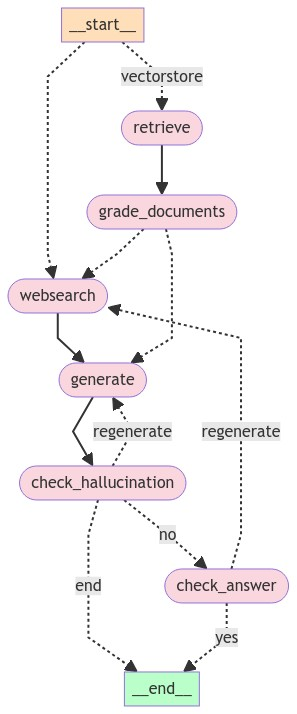

In [58]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeColors

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [59]:
inputs = {"question": "What matrixes are part of attention?"}
for output in app.stream(inputs):
    for key, value in output.items():
        print(f"Finished running: {key}:")
print(value["generation"])

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
-- RETRIEVE --
Finished running: retrieve:
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
Finished running: grade_documents:
---GENERATE---
Finished running: generate:
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
Finished running: check_hallucination:
---CHECK GENERATON ADDRESSES QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
---ASSESS HALLUCINATIONS---
Finished running: check_answer:
The matrixes that are part of attention include the query matrix (Q), the key matrix (K), and the value matrix (V). These matrices are used in the computation of the attention function in the context of Scaled Dot-Product Attention. The attention function involves operations on these matrices to calculate the weights assigned to the values.


In [60]:
inputs = {"question": "What is a decoder only architecture?"}
for output in app.stream(inputs):
    for key, value in output.items():
        print(f"Finished running: {key}:")
print(value["generation"])

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
-- RETRIEVE --
Finished running: retrieve:
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: NOT ALL DOCUMENTS ARE RELEVANT TO QUESTION, INCLUDE WEB SEARCH---
Finished running: grade_documents:
---WEB SEARCH---
Finished running: websearch:
---GENERATE---
Finished running: generate:
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
Finished running: check_hallucination:
---CHECK GENERATON ADDRESSES QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
---ASSESS HALLUCINATIONS---
Finished running: check_answer:
A decoder-only architecture is a model that consists of only a decoder, trained to predict the next token in a sequence given the previous tokens. Unlike the Encoder-Decoder architecture, the Decoder-only architecture does not have

In [61]:
inputs = {"question": "Andrej Karpathy just released GPT-2 the movie where he used flash attention to optimize the training time. Who is Andrej Karpathy?"}
for output in app.stream(inputs):
    for key, value in output.items():
        print(f"Finished running: {key}:")
print(value["generation"])

---ROUTE QUESTION---
---ROUTE QUESTION TO WEB SEARCH---
---WEB SEARCH---
Finished running: websearch:
---GENERATE---
Finished running: generate:
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
Finished running: check_hallucination:
---CHECK GENERATON ADDRESSES QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
---ASSESS HALLUCINATIONS---
Finished running: check_answer:
Andrej Karpathy is an artificial intelligence researcher and one of the founding members of OpenAI. He completed his Computer Science and Physics bachelor's degrees at the University of Toronto and received his master's degree at the University of British Columbia. Karpathy specializes in deep learning and computer vision.


In [62]:
inputs = {"question": "Who is Andrej Karpathy?"}
for output in app.stream(inputs):
    for key, value in output.items():
        print(f"Finished running: {key}:")
print(value["generation"])

---ROUTE QUESTION---
---ROUTE QUESTION TO WEB SEARCH---
---WEB SEARCH---
Finished running: websearch:
---GENERATE---
Finished running: generate:
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
Finished running: check_hallucination:
---CHECK GENERATON ADDRESSES QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
---ASSESS HALLUCINATIONS---
Finished running: check_answer:
Andrej Karpathy is a computer scientist specializing in deep learning and computer vision. He completed his PhD at Stanford University in 2016 under the supervision of Fei-Fei Li. Karpathy is a founding member of the artificial intelligence research group OpenAI.


In [63]:
os.listdir('./papers/')

['FlashAttention: Fast and Memory-Efficient Exact Attention with IO-Awareness',
 'Self-RAG: Learning to Retrieve, Generate, and Critique through Self-Reflection',
 'Adaptive-RAG: Learning to Adapt Retrieval-Augmented Large Language Models through Question Complexity',
 'Attention Is All You Need',
 'Language Models are Few-Shot Learners',
 'Corrective Retrieval Augmented Generation']

In [72]:
list(set([v['source'] for v in vectorstore.get()["metadatas"]]))

['./papers_dir/AttentionIsAllYouNeed.pdf',
 './papers_dir/Self-RAG:LearningtoRetrieve,Generate,andCritiquethroughSelf-Reflection.pdf',
 './papers_dir/Adaptive-RAG:LearningtoAdaptRetrieval-AugmentedLargeLanguageModelsthroughQuestionComplexity.pdf',
 './papers_dir/CorrectiveRetrievalAugmentedGeneration.pdf',
 './papers_dir/LanguageModelsareFew-ShotLearners.pdf',
 './papers_dir/FlashAttention:FastandMemory-EfficientExactAttentionwithIO-Awareness.pdf']